# mess around with scipy voronoi

In [ ]:
from scipy.spatial import Voronoi
x=[0,1,0,1,0,1,0,1,0,1]
y=[0,0,1,1,2,2,3,3.5,4,4.5]
z=[0,0,0,0,0,1,1,1,1,1]
points2d = list(zip(x,y))
points3d = list(zip(x,y,z))

In [ ]:
# plot the 3d points on euclidean space
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()

In [ ]:
# plot the voronoi diagram of 2d points
from scipy.spatial import voronoi_plot_2d
v = Voronoi(points2d)
voronoi_plot_2d(v);

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

In [ ]:
voronoi_volumes(points2d)

In [ ]:
# generate 1000 random points in 2d
x = np.random.rand(50)
y = np.random.rand(50)
points = list(zip(x,y))

# plot the voronoi diagram of 1000 random points
v = Voronoi(points)
voronoi_plot_2d(v);

In [ ]:
voronoi_volumes(points)

# plug kmeans density estimate

In [ ]:
from rum.manifold.euclidean import EuclideanManifold
m = EuclideanManifold(dim=2, sampler={'type': 'uniform', 'low': -1, 'high': 1})
s = m.random_walk(n=1000)

In [ ]:
from rum.density.kmeans import KMeansDensityEstimator
kmeans = KMeansDensityEstimator(k=50, dim_states=2)

In [ ]:
from matplotlib import pyplot as plt
points2d = kmeans.centroids.numpy()
plt.scatter(points2d[:,0], points2d[:,1], label='kmeans centers', s=5)
plt.legend()

In [ ]:
centers = kmeans.centroids.numpy()
diameters = kmeans.diameters.numpy()
radius = diameters / 2

fig, ax = plt.subplots()
ax.scatter(centers[:,0], centers[:,1], s=5)
for i in range(len(centers)):
    circle = plt.Circle((centers[i,0], centers[i,1]), radius[i], fill=False)
    ax.add_artist(circle)
plt.show()

In [ ]:
from scipy.spatial import voronoi_plot_2d, Voronoi
voronoi_plot_2d(Voronoi(kmeans.centroids.numpy()));

In [ ]:
centers = kmeans.centroids.numpy()
diameters = kmeans.diameters.numpy()
radius = diameters / 2

vor = Voronoi(centers)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, point_size=3, show_vertices=False)

# Overlay the circles onto the Voronoi diagram
for i, center in enumerate(centers):
    circle = plt.Circle(center, radius[i], color='orange', fill=False)
    ax.add_artist(circle)

plt.show()

# actually run the kmeans estimate

In [ ]:
def voroplot(ax, kmeans):
    centers = kmeans.centroids.numpy()
    diameters = kmeans.diameters.numpy()
    radius = diameters / 2

    vor = Voronoi(centers)

    # Plot the Voronoi diagram
    voronoi_plot_2d(vor, ax=ax, point_size=3, show_vertices=False)

    # Overlay the circles onto the Voronoi diagram
    for i, center in enumerate(centers):
        circle = plt.Circle(center, radius[i], color='orange', fill=False)
        ax.add_artist(circle)

    return ax

In [ ]:
from rum.manifold.euclidean import EuclideanManifold
m = EuclideanManifold(dim=2, sampler={'type': 'uniform', 'low': -1, 'high': 1})
s = m.random_walk(n=1000)

In [ ]:
plt.scatter(s[:,0], s[:,1], label='traj', s=1, color='red')

In [ ]:
from rum.density.kmeans import KMeansDensityEstimator
kmeans = KMeansDensityEstimator(k=50, dim_states=2)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
voroplot(ax, kmeans)

In [ ]:
# trajectory movie

from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(6, 6))
steps = len(s)

def trajectory(idx):
    ax.clear()
    lb = min(0, idx-50)
    plt.scatter(s[lb:idx, 0], s[lb:idx, 1], label='traj', s=1, color='red')

ani = FuncAnimation(fig, trajectory, frames=steps, repeat=False)
ani.save('traj.mp4', writer='ffmpeg', fps=10)
plt.close(fig)

In [ ]:
import torch
s = torch.Tensor(m.random_walk(n=1000))
c1 = kmeans.centroids.clone().numpy()
kmeans.learn(s)
c2 = kmeans.centroids.clone().numpy()
print((c2 - c1)[:10])

# all in!

In [1]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import voronoi_plot_2d, Voronoi
from scipy.spatial import ConvexHull
from scipy.special import gamma

from rum.density.kmeans import KMeansDensityEstimator
from rum.manifold.euclidean import EuclideanManifold

import numpy as np
import torch
import math

def voroplot(ax, kmeans):
    centers = kmeans.centroids.numpy()
    diameters = kmeans.diameters.numpy()
    radius = diameters / 2
    vor = Voronoi(centers)
    voronoi_plot_2d(vor, ax=ax, point_size=3, show_vertices=False)
    for i, center in enumerate(centers):
        circle = plt.Circle(center, radius[i], color='orange', fill=False)
        ax.add_artist(circle)

def trajplot(ax, states, idx, buffer=50):
    lb = max(0, idx-buffer)
    states = states.numpy()
    ax.scatter(states[lb:idx, 0], states[lb:idx, 1], label='walk', s=1, color='red')

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

def volume_nsphere(radius, n):
    volume = (math.pi ** (n / 2)) / gamma((n / 2) + 1) * (radius ** n)
    return volume

def compute_ratio(kmeans):
    points = kmeans.centroids.numpy()
    vor = Voronoi(points)
    radius = (kmeans.diameters / 2).numpy()
    clusters_vols = [volume_nsphere(r, dim) for r in radius]
    voronoi_vols = voronoi_volumes(points)
    ratio = clusters_vols / voronoi_vols
    ratio = ratio[ratio != 0]
    avg_ratio = ratio.mean()
    return avg_ratio

k, dim = 300, 2
x_low, x_high = -1, 1

m = EuclideanManifold(dim=dim, sampler={'type': 'uniform', 'low': x_low, 'high': x_high})
kmeans = KMeansDensityEstimator(k=k, dim_states=dim)
states = torch.Tensor(m.random_walk(n=5000))

fig, ax = plt.subplots(figsize=(6, 6))
ratios = []

def movie(idx):
    s = states[idx].view(-1, dim)
    kmeans.learn(s)
    ax.clear()
    voroplot(ax, kmeans)
    trajplot(ax, states, idx)
    ax.set_xlim(x_low, x_high)
    ax.set_ylim(x_low, x_high)
    ax.set_title(f'kmeans density estimate live k={k}')
    ax.legend(loc='upper left')
    ratios.append(compute_ratio(kmeans))

# Create an animation by repeatedly calling update
ani = FuncAnimation(fig, movie, frames=range(len(states)), repeat=False)
ani.save(f'kmeans-{k}.mp4', writer='ffmpeg', fps=200)
plt.close(fig)

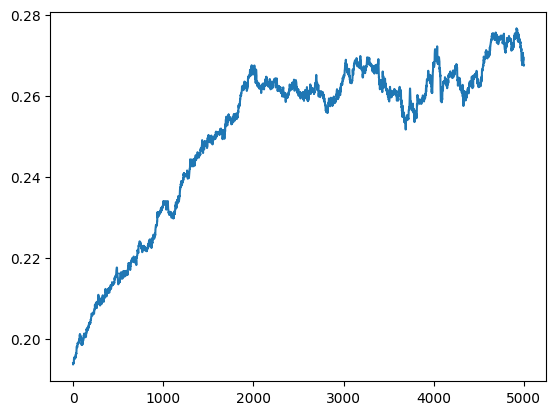

In [2]:
# avg ratio
plt.plot(ratios)